# Input the data

In [141]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

## load dataset (clinical_info)

In [142]:
folder_path = Path('../data/Shanghai_diabetes_datasets/clinical_info/csv')

if not os.path.exists(folder_path):
    raise FileNotFoundError(f"directory {folder_path} doesn't exist")

df1 = pd.read_csv(folder_path.joinpath('Shanghai_T1DM_Summary.csv'))
df2 = pd.read_csv(folder_path.joinpath('Shanghai_T2DM_Summary.csv'))

combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df.head(9)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no),Comorbidities
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,3.59,1.02,0.86,2.01,37.3,160,188.86,6.47,no,"hypertension, osteoporosis, thyroid nodule, pu..."
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,4.78,2.2,0.93,3.28,66.8,109,342.57,6.05,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,4.78,2.2,0.93,3.28,69.4,104,322.18,3.06,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,3.49,1.82,0.84,1.83,63.7,115,342.34,6.21,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,5.61,1.14,1.08,3.95,49.6,174,93.39,1.85,yes,"leucopenia, hypokalemia, hepatic dysfunction"
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,4.57,0.91,1.27,2.76,45.2,127,240.61,3.98,yes,"hypocalcemia, thyroid nodule, osteoporosis"
6,1005_0_20210522,2,58,1.70,50,17.30,22.5,non-drinker,T1DM,16.00,...,4.05,0.46,1.57,2.12,75.4,98,205.48,3.96,yes,"thyroid nodule, prostatic hyperplasia, osteopo..."
7,1006_0_20210114,2,57,1.61,53,20.52,0.0,non-drinker,T1DM,7.00,...,4.44,0.68,1.97,2.57,74.0,97,247.00,6.40,yes,none
8,1006_1_20210209,2,57,1.61,52,20.18,0.0,non-drinker,T1DM,7.00,...,5.12,0.64,1.88,2.93,82.0,91,257.00,6.40,yes,none


## handling missing values

In [143]:
combined_df.replace('/', pd.NA, inplace=True)  # convert / to null

cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]

for col in cols_to_fill:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col].astype(str).str.strip(), errors='coerce')

combined_df[cols_to_fill] = combined_df[cols_to_fill].fillna(combined_df[cols_to_fill].median())

## analyse data

In [144]:
combined_df.describe()

,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Duration of Diabetes (years),Fasting Plasma Glucose (mg/dl),2-hour Postprandial Plasma Glucose (mg/dl),Fasting C-peptide (nmol/L),...,HbA1c (mmol/mol),Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L)
count,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000
mean,1.544000,60.136000,1.655120,65.216000,23.72184,4.533600,9.059680,168.346080,263.586240,0.400936,...,75.14400,24.428000,4.785280,1.670960,1.159600,3.072320,63.012000,116.76000,320.734320,5.831440
std,0.500065,13.547017,0.094627,11.984253,3.46806,13.181143,8.399958,65.815955,84.357438,0.264888,...,26.50919,8.869616,0.990184,0.966817,0.352924,0.894042,18.655301,40.02608,89.379685,1.698329
min,1.000000,22.000000,1.420000,35.000000,13.67000,0.000000,0.010000,55.800000,72.540000,0.007000,...,23.00000,7.100000,2.510000,0.460000,0.690000,0.980000,22.600000,34.00000,93.390000,1.810000
25%,1.000000,52.000000,1.600000,56.000000,21.89000,0.000000,1.000000,124.920000,212.580000,0.230000,...,55.00000,19.500000,4.270000,1.080000,0.930000,2.520000,52.400000,99.00000,262.400000,5.210000
50%,2.000000,62.000000,1.650000,65.000000,23.44000,0.000000,7.000000,158.400000,256.320000,0.370000,...,68.00000,22.400000,4.690000,1.540000,1.080000,3.080000,62.800000,108.00000,317.030000,5.600000
75%,2.000000,68.000000,1.720000,72.000000,25.30000,0.000000,15.000000,194.400000,304.200000,0.500000,...,93.00000,28.200000,5.310000,1.810000,1.290000,3.690000,70.400000,126.00000,355.960000,6.400000
max,2.000000,97.000000,1.900000,100.000000,36.73000,80.000000,40.000000,432.000000,610.380000,1.240000,...,166.00000,71.100000,7.790000,7.650000,2.560000,5.270000,136.100000,286.00000,563.960000,15.580000


## handling duplicates

In [145]:
duplicate_rows_data = combined_df[combined_df.duplicated()]
print('duplicate_rows_data', duplicate_rows_data)

duplicate_rows_data Empty DataFrame
Columns: [Patient Number, Gender (Female=1, Male=2), Age (years), Height (m), Weight (kg), BMI (kg/m2), Smoking History (pack year), Alcohol Drinking History (drinker/non-drinker), Type of Diabetes, Duration of Diabetes (years), Acute Diabetic Complications, Diabetic Macrovascular  Complications, Diabetic Microvascular Complications, Hypoglycemic Agents, Other Agents, Fasting Plasma Glucose (mg/dl), 2-hour Postprandial Plasma Glucose (mg/dl), Fasting C-peptide (nmol/L), 2-hour Postprandial C-peptide (nmol/L), Fasting Insulin (pmol/L), 2-hour Postprandial Insulin (pmol/L), HbA1c (mmol/mol), Glycated Albumin (%), Total Cholesterol (mmol/L), Triglyceride (mmol/L), High-Density Lipoprotein Cholesterol (mmol/L), Low-Density Lipoprotein Cholesterol (mmol/L), Creatinine (umol/L), Estimated Glomerular Filtration Rate  (ml/min/1.73m2), Uric Acid (mmol/L), Blood Urea Nitrogen (mmol/L), Hypoglycemia (yes/no), Comorbidities]
Index: []

[0 rows x 33 columns]


## uniqueness

In [146]:
for column in combined_df.columns:
    unique_value = len(combined_df[column].unique())
    print(f'{column}: {unique_value} quantity unique value')

Patient Number: 125 quantity unique value
Gender (Female=1, Male=2): 2 quantity unique value
Age (years): 45 quantity unique value
Height (m): 35 quantity unique value
Weight (kg): 42 quantity unique value
BMI (kg/m2): 100 quantity unique value
Smoking History (pack year): 15 quantity unique value
Alcohol Drinking History (drinker/non-drinker): 2 quantity unique value
Type of Diabetes: 2 quantity unique value
Duration of Diabetes (years): 36 quantity unique value
Acute Diabetic Complications: 2 quantity unique value
Diabetic Macrovascular  Complications: 8 quantity unique value
Diabetic Microvascular Complications: 8 quantity unique value
Hypoglycemic Agents: 78 quantity unique value
Other Agents: 70 quantity unique value
Fasting Plasma Glucose (mg/dl): 81 quantity unique value
2-hour Postprandial Plasma Glucose (mg/dl): 96 quantity unique value
Fasting C-peptide (nmol/L): 62 quantity unique value
2-hour Postprandial C-peptide (nmol/L): 59 quantity unique value
Fasting Insulin (pmol/L)

## emissions

In [147]:
for col in cols_to_fill:
    q1 = combined_df[col].quantile(0.25)
    q3 = combined_df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = combined_df[(combined_df[col] < lower) | (combined_df[col] > upper)]
    print(f'{col}: {len(outliers)} emissions')

Age (years): 2 emissions
Height (m): 1 emissions
Weight (kg): 2 emissions
BMI (kg/m2): 7 emissions
Smoking History (pack year): 22 emissions
Duration of Diabetes (years): 1 emissions
Fasting Plasma Glucose (mg/dl): 7 emissions
2-hour Postprandial Plasma Glucose (mg/dl): 5 emissions
Fasting C-peptide (nmol/L): 8 emissions
2-hour Postprandial C-peptide (nmol/L): 24 emissions
Fasting Insulin (pmol/L): 12 emissions
2-hour Postprandial Insulin (pmol/L): 62 emissions
HbA1c (mmol/mol): 1 emissions
Glycated Albumin (%): 5 emissions
Total Cholesterol (mmol/L): 5 emissions
Triglyceride (mmol/L): 10 emissions
High-Density Lipoprotein Cholesterol (mmol/L): 10 emissions
Low-Density Lipoprotein Cholesterol (mmol/L): 0 emissions
Creatinine (umol/L): 7 emissions
Estimated Glomerular Filtration Rate  (ml/min/1.73m2): 17 emissions
Uric Acid (mmol/L): 7 emissions
Blood Urea Nitrogen (mmol/L): 14 emissions


## correction emissions

In [148]:
combined_df = combined_df[combined_df['Fasting Insulin (pmol/L)'] < 700]
combined_df = combined_df[combined_df['2-hour Postprandial Insulin (pmol/L)'] < 800]

## fix faulty values

In [149]:
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('raberazole', 'rabeprazole')
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('calcium carbonate and vitamin D3 tablet',
                                                                      'calcium carbonate, vitamin D3 tablet')
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('rosuvastatinqn', 'rosuvastatin')
combined_df['Other Agents'] = combined_df['Other Agents'].str.replace('nifedipine doxazosin', 'nifedipine, doxazosin')

# grouped columns

## find_unknown_agents

In [150]:
def find_unknown_agents(df, col_name, items_to_group):
    all_agents = set()

    for elem in df[col_name]:
        agents = [agent.strip() for agent in elem.split(',')]
        all_agents.update(agents)

    unknown_agents = sorted(
        [unk_ag for unk_ag in all_agents if unk_ag not in items_to_group and unk_ag.lower() != 'none'])

    for unk_ag in unknown_agents: print(unk_ag)

## add_group_flags

In [151]:
def add_group_flags(df, column_name, items_to_group):
    all_groups = sorted(set(items_to_group.values()))

    def parse_agents(row):
        if pd.isna(row): return []
        return [agent.strip() for agent in row.split(',')]

    for group in all_groups:
        df[f'has_{group}'] = df[column_name].apply(
            lambda x: int(any(items_to_group.get(agent) == group for agent in parse_agents(x)))
        )

    df = df.drop(columns=[column_name], axis=1)
    return df

## Other Agents

In [152]:
drug_to_group = {
    # hypolipidemic
    'pravastatin': 'hypolipidemic',
    'rosuvastatin': 'hypolipidemic',
    'fenofibrate': 'hypolipidemic',
    'ezetimibe': 'hypolipidemic',
    'atorvastatin': 'hypolipidemic',

    # angioprotectors
    'calcium dobesilate': 'angioprotectors',
    'beiprostaglandin sodium': 'angioprotectors',

    # ace inhibitors
    'benazepril': 'ace_inhibitors',

    # minerals and vitamins
    'potassium chloride': 'minerals_and_vitamins',
    'calcium carbonate': 'minerals_and_vitamins',
    'calcitriol': 'minerals_and_vitamins',
    'multivitamin': 'minerals_and_vitamins',
    'vitamin B1': 'minerals_and_vitamins',
    'vitamin D3 tablet': 'minerals_and_vitamins',
    'mecobalamin': 'minerals_and_vitamins',

    # probiotics
    'clostridium butyricum': 'probiotics',

    # ARB
    'telmisartan': 'arb',
    'valsartan': 'arb',
    'olmesartan medoxomil': 'arb',
    'olmesartan': 'arb',
    'losartan': 'arb',
    'losartan/hydrochlorothiazide': 'arb',
    'irbesartan': 'arb',
    'candesartan': 'arb',
    'allisartan': 'arb',

    # psychotropic
    'quetiapine': 'psychotropic',

    # antianginal
    'isosorbide mononitrate': 'antianginal',

    # gout treatment
    'febuxostat': 'gout_treatment',

    # laxatives
    'bisacodyl': 'laxatives',

    # urological drugs
    'Qianlie Shutong capsule  (Chinese patent drug for prostatic hyperplasia)': 'urological_drugs',

    # calcium channel blockers
    'nifedipine': 'calcium_channel_blockers',
    'amlodipine': 'calcium_channel_blockers',
    'felodipine': 'calcium_channel_blockers',
    'benidipine': 'calcium_channel_blockers',

    # antiarrhythmic
    'doxazosin': 'antiarrhythmic',
    'labetalol': 'antiarrhythmic',
    'bisoprolol': 'antiarrhythmic',
    'metoprolol': 'antiarrhythmic',

    # gastroprotective
    'rabeprazole': 'gastroprotective',

    # circulatory support
    'Yinxingye tablet (extract of Ginkgo biloba leaves)': 'circulatory_support',

    # antithrombotic
    'aspirin': 'antithrombotic',
    'clopidogrel': 'antithrombotic',
    'rivaroxaban': 'antithrombotic',

    # vasodilators
    'trimetazidine': 'vasodilators',
    'magnesium isoglycyrrhizinate': 'vasodilators',

    # pancreatic
    'pancreatic kininogenase': 'pancreatic',

    # neuroprotectors
    'epalrestat': 'neuroprotectors',

    # kidney support
    'compound α-keto acid tablet': 'kidney_support',
    'Shen Shuai Ning capsule (Chinese patent drug for renal dysfunction)': 'kidney_support',

    # hepatoprotector
    'polyene phosphatidylcholine': 'hepatoprotector',
    'diammonium glycyrrhizinate': 'hepatoprotector',

    # immunomodulators
    'leucogen': 'immunomodulators',

    # thyroid diseases
    'levothyroxine': 'thyroid_diseases',

    # antibiotics
    'levofloxacin': 'antibiotics',

    # antihypertensives
    'Zhenju Jiangya tablet (Chinese patent drug for hypertension)': 'antihypertensives',

    # vestibular disorders
    'betahistine': 'vestibular_disorders',
}

In [153]:
find_unknown_agents(combined_df, 'Other Agents', drug_to_group)
combined_df = add_group_flags(combined_df, 'Other Agents', drug_to_group)
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_laxatives,has_minerals_and_vitamins,has_neuroprotectors,has_pancreatic,has_probiotics,has_psychotropic,has_thyroid_diseases,has_urological_drugs,has_vasodilators,has_vestibular_disorders
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,1,0,0,0,0,0,0,0,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,0,1,0,0,0,0,0,0,0,0
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,0,1,0,0,0,0,0,0,0,0
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,0,1,0,0,0,0,0,0,0,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,1,1,0,0,0,0,0,0,0


## Comorbidities

In [154]:
disease_to_group = {
    # diseases_of_the_stomach_and_intestines
    'chronic atrophic gastritis': 'diseases_of_the_stomach_and_intestines',
    'colorectal polyp': 'diseases_of_the_stomach_and_intestines',
    'chronic gastritis': 'diseases_of_the_stomach_and_intestines',
    'gastric polyp': 'diseases_of_the_stomach_and_intestines',

    # diseases_of_the_musculoskeletal_system
    'lumbar herniated disc': 'diseases_of_the_musculoskeletal_system',
    'osteopenia': 'diseases_of_the_musculoskeletal_system',
    'osteoporosis': 'diseases_of_the_musculoskeletal_system',
    'lumbar spine tumor': 'diseases_of_the_musculoskeletal_system',

    # cardiovascular_diseases
    'myocardial bridging': 'cardiovascular_diseases',
    'sinus arrhythmia': 'cardiovascular_diseases',
    'hypertension': 'cardiovascular_diseases',
    'hyperlipidemia': 'cardiovascular_diseases',
    'sinus bradycardia': 'cardiovascular_diseases',
    'atrial fibrillation': 'cardiovascular_diseases',

    # kidney_diseases
    'kidney cyst': 'kidney_diseases',
    'hydronephrosis': 'kidney_diseases',
    'nephrolithiasis': 'kidney_diseases',
    'urinary tract infection': 'kidney_diseases',

    # dental_diseases
    'periodontitis': 'dental_diseases',

    # gynecological_diseases
    'hysteromyoma': 'gynecological_diseases',

    # neurological_and_psychiatric_diseases
    'anxiety': 'neurological_and_psychiatric_diseases',
    'cerebrovascular disease': 'neurological_and_psychiatric_diseases',
    "Alzheimer's disease": 'neurological_and_psychiatric_diseases',
    "Parkinson's disease": 'neurological_and_psychiatric_diseases',

    # liver_diseases
    'fatty liver disease': 'liver_diseases',
    'fatty liver disese': 'liver_diseases',
    'liver cyst': 'liver_diseases',
    'hepatic dysfunction': 'liver_diseases',

    # gallbladder_diseases
    'cholecystitis': 'gallbladder_diseases',
    'cholelithiasis': 'gallbladder_diseases',
    'gallbladder polyp': 'gallbladder_diseases',

    # infectious_diseases
    'chronic hepatitis B': 'infectious_diseases',

    # oncology
    'breast cancer': 'oncology',
    'pancreatic cancer': 'oncology',
    'parotid gland carcinoma': 'oncology',
    'lung lesion': 'oncology',
    'pulmonary nodule': 'oncology',

    # endocrine_diseases
    'hypoparathyroidism': 'endocrine_diseases',
    'hypothyroidism': 'endocrine_diseases',
    'enlarged adrenal gland': 'endocrine_diseases',
    'thyroid nodule': 'endocrine_diseases',

    # male_reproductive_diseases
    'prostatic hyperplasia': 'male_reproductive_diseases',

    # eye_diseases
    'cataract': 'eye_diseases',
    'conjunctivitis': 'eye_diseases',

    # hematologic_disorders
    'hypoleukocytemia': 'hematologic_disorders',
    'leucopenia': 'hematologic_disorders',

    # autoimmune_diseases
    'systemic sclerosis': 'autoimmune_diseases',
    'psoriasis': 'autoimmune_diseases',

    # electrolyte_and_mineral_disorders
    'hypocalcemia': 'electrolyte_and_mineral_disorders',
    'hypokalemia': 'electrolyte_and_mineral_disorders',
    'vitamin D deficiency': 'electrolyte_and_mineral_disorders',
    'hyperuricemia': 'electrolyte_and_mineral_disorders',
}

In [155]:
find_unknown_agents(combined_df, 'Comorbidities', disease_to_group)
combined_df = add_group_flags(combined_df, 'Comorbidities', disease_to_group)
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_eye_diseases,has_gallbladder_diseases,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,0,0,1,1,0,0,1
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,0,0,1,0,0,1,0,0,0


In [156]:
combined_df.shape

(122, 74)

## drop unused columns

In [157]:
combined_df = combined_df.drop(columns=['Hypoglycemic Agents'])

In [158]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_eye_diseases,has_gallbladder_diseases,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,0,0,1,1,0,0,1
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,0,0,1,0,0,1,0,0,0


# specify has_macrovascular and has_microvascular complications

In [159]:
def specify_has_or_no(df, column_name):
    column_name = column_name.strip()

    def has_any_value(row):
        if pd.isna(row): return 0
        for el in row.split(','):
            el = el.strip().lower()
            if el and el != 'none':
                return 1
        return 0

    new_name_column = f'has_{column_name.lower().replace(' ', '_')}'
    df[new_name_column] = df[column_name].apply(has_any_value)

    return df

In [160]:
combined_df = specify_has_or_no(combined_df, 'Diabetic Microvascular Complications')

combined_df = combined_df.drop(columns=['Diabetic Microvascular Complications'])

combined_df

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_gallbladder_diseases,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,0,1,1,0,0,1,1
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,1
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,1
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,0,1
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2095_0_20201116,2,66,1.72,62,20.96,0.0,non-drinker,T2DM,7.00,...,0,0,0,0,0,0,0,0,0,0
121,2096_0_20201116,1,60,1.57,65,26.37,0.0,non-drinker,T2DM,0.10,...,0,0,0,0,0,1,0,0,0,0
122,2097_0_20201116,1,71,1.70,67,23.11,0.0,non-drinker,T2DM,20.00,...,0,0,0,0,0,0,0,0,0,0
123,2098_0_20201106,1,64,1.60,67,26.17,0.0,non-drinker,T2DM,0.10,...,0,0,0,0,0,1,0,0,0,0


In [161]:
combined_df = specify_has_or_no(combined_df, 'Diabetic Macrovascular  Complications')

combined_df = combined_df.drop(columns=['Diabetic Macrovascular  Complications'])

combined_df.head(6)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_gynecological_diseases,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,0,1,1,0,0,1,1,1
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,1,1
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,1,1
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,0,1,1
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,0,1,0,0,1,0,0,0,1,0
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,0,0,0,0,0,0,0,0,1,1


In [162]:
combined_df = specify_has_or_no(combined_df, 'Acute Diabetic Complications')

combined_df = combined_df.drop(columns=['Acute Diabetic Complications'])

combined_df.head(8)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,0,0,1,1,0,0,1,1,1,0
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,1
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,1
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,0,0,0,0,0,0,0,1,1,0
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,1,0,0,1,0,0,0,1,0,1
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,0,0,0,0,0,0,0,1,1,0
6,1005_0_20210522,2,58,1.70,50,17.30,22.5,non-drinker,T1DM,16.00,...,0,1,0,0,1,0,0,0,0,0
7,1006_0_20210114,2,57,1.61,53,20.52,0.0,non-drinker,T1DM,7.00,...,0,0,0,0,0,0,0,0,0,0


## encoding columns Alcohol Drinking History (drinker/non-drinker) and Hypoglycemia (yes/no)

Hypoglycemia (yes/no) -> (yes 1 / no 0)
Alcohol Drinking History (drinker/non-drinker) -> (yes 0 / no 1)

In [163]:
label_encoder = preprocessing.LabelEncoder()

for col_to_encode in ['Alcohol Drinking History (drinker/non-drinker)', 'Hypoglycemia (yes/no)', 'Type of Diabetes']:
    combined_df[col_to_encode] = label_encoder.fit_transform(combined_df[col_to_encode])

combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_hematologic_disorders,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,0,10.00,...,0,0,1,1,0,0,1,1,1,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,0,26.00,...,0,0,0,0,0,0,0,1,1,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,0,26.00,...,0,0,0,0,0,0,0,1,1,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,0,26.00,...,0,0,0,0,0,0,0,1,1,0
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,0,0.08,...,1,0,0,1,0,0,0,1,0,1


## rename Hypoglycemia (yes/no)

In [164]:
combined_df[f'has_hypoglycemia'] = combined_df['Hypoglycemia (yes/no)']

In [165]:
df = combined_df.drop(columns=['Hypoglycemia (yes/no)'])
df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications,has_hypoglycemia
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,0,10.00,...,0,1,1,0,0,1,1,1,0,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,0,26.00,...,0,0,0,0,0,0,1,1,1,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,0,26.00,...,0,0,0,0,0,0,1,1,1,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,0,26.00,...,0,0,0,0,0,0,1,1,0,1
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,0,0.08,...,0,0,1,0,0,0,1,0,1,1


In [166]:
df.columns

Index(['Patient Number', 'Gender (Female=1, Male=2)', 'Age (years)',
       'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
       'Smoking History (pack year)',
       'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
       'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
       '2-hour Postprandial Plasma Glucose (mg/dl)',
       'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)',
       'Fasting Insulin (pmol/L)', '2-hour Postprandial Insulin (pmol/L)',
       'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
       'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
       'High-Density Lipoprotein Cholesterol (mmol/L)',
       'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
       'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
       'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)',
       'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
       'has_antiarrhythmic', 'has_antibiot

# indicating therapy_type

In [167]:
folder_Shanghai_T1DM = Path('../data/Shanghai_diabetes_datasets/Shanghai_CSV-Data/T1DM')
folder_Shanghai_T2DM = Path('../data/Shanghai_diabetes_datasets/Shanghai_CSV-Data/T2DM')

## converting check

In [168]:
folder_excel = Path('../data/Shanghai_diabetes_datasets/Shanghai_T2DM/')
folder_csv = Path('../data/Shanghai_diabetes_datasets/Shanghai_CSV-Data/T2DM')

excel_names = {file.stem for file in folder_excel.glob('*.xlsx')} | \
              {file.stem for file in folder_excel.glob('*.xls')}

csv_names = {f.stem for f in folder_csv.glob('*.csv')}

missing_converted = excel_names - csv_names

if missing_converted:
    print("The following Excel files were not converted to CSV:")
    for name in sorted(missing_converted):
        print(name + ' (missing .csv)')
else:
    print("All Excel files were successfully converted to CSV.")

All Excel files were successfully converted to CSV.


## determine_treatment

In [169]:
def determine_treatment(file_path):
    df = pd.read_csv(file_path)
    treatments = []

    if 'Insulin dose - s.c.' in df.columns and df['Insulin dose - s.c.'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('s.c. insulin')

    if 'Insulin dose - i.v.' in df.columns and df['Insulin dose - i.v.'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('i.v. insulin')

    if 'CSII - bolus insulin (Novolin R, IU)' in df.columns and df[
        'CSII - bolus insulin (Novolin R, IU)'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('CSII bolus')

    if 'CSII - basal insulin (Novolin R, IU / H)' in df.columns and df[
        'CSII - basal insulin (Novolin R, IU / H)'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('CSII basal')

    if 'Non-insulin hypoglycemic agents' in df.columns and df['Non-insulin hypoglycemic agents'].dropna().astype(
            str).str.strip().ne('').any():
        treatments.append('non-insulin agents')

    return '; '.join(treatments)

In [170]:
treatment_map_1 = {}
treatment_map_2 = {}

for file in folder_Shanghai_T1DM.glob('*.csv'):
    for patient_id in df['Patient Number']:
        if patient_id in file.name:
            treatment_map_1[patient_id] = determine_treatment(file)
            break

for file in folder_Shanghai_T2DM.glob('*.csv'):
    for patient_id in df['Patient Number']:
        if patient_id in file.name:
            treatment_map_2[patient_id] = determine_treatment(file)
            break

treatment_map = {**treatment_map_1, **treatment_map_2}

df['treatment'] = df['Patient Number'].map(treatment_map)
df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications,has_hypoglycemia,treatment
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,0,10.00,...,1,1,0,0,1,1,1,0,0,CSII bolus; CSII basal; non-insulin agents
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,0,26.00,...,0,0,0,0,0,1,1,1,1,s.c. insulin; i.v. insulin; CSII bolus; CSII b...
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,0,26.00,...,0,0,0,0,0,1,1,1,1,s.c. insulin; CSII bolus; CSII basal
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,0,26.00,...,0,0,0,0,0,1,1,0,1,CSII bolus; CSII basal
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,0,0.08,...,0,1,0,0,0,1,0,1,1,s.c. insulin; i.v. insulin; CSII bolus; CSII b...


## deleted null treatment

In [171]:
df = df[df['treatment'].notna()]

# folder_path = Path('../data/Shanghai_diabetes_datasets/3_step_finish_dataset/3_step_finish_dataset.csv')
# df.to_csv(folder_path)

## grouped non-insulin, insulin treatment or mixed

In [172]:
def classify_treatment(df):
    insulin_treatments = {'CSII bolus', 'CSII basal', 's.c. insulin', 'i.v. insulin'}
    non_insulin_treatment = 'non-insulin agents'

    def classify(row):

        treatments = set([value.strip() for value in row.split(';')])

        has_insulin = bool(treatments.intersection(insulin_treatments))
        has_non_insulin = non_insulin_treatment in treatments

        if has_insulin and has_non_insulin:
            return 'mixed_treatment'
        elif has_insulin:
            return 'insulin_treatment'
        elif has_non_insulin:
            return 'drug_treatment'
        else:
            return None

    df['treatment_type'] = df['treatment'].apply(classify)

    df = df.dropna(subset=['treatment_type'])

    return df


df = classify_treatment(df)
folder_path = Path('../data/Shanghai_diabetes_datasets/3_step_finish_dataset/3_step_finish_dataset.csv')
df.to_csv(folder_path)

In [173]:
# def classify_treatment(df):
#     insulin_treatments = {'CSII bolus', 'CSII basal', 's.c. insulin', 'i.v. insulin'}
#     non_insulin_treatment = 'non-insulin agents'
#
#     def classify(row):
#         treatments = set([value.strip() for value in row.split(';')])
#
#         has_insulin = bool(treatments.intersection(insulin_treatments))
#         has_non_insulin = non_insulin_treatment in treatments
#
#         if has_insulin:
#             return 'insulin_treatment'
#         elif has_non_insulin:
#             return 'drug_treatment'
#         else:
#             return None
#
#     df['treatment_type'] = df['treatment'].apply(classify)
#
#     df = df.dropna(subset=['treatment_type'])
#
#     return df
#
#
# df = classify_treatment(df)
# folder_path = Path('../data/Shanghai_diabetes_datasets/3_step_finish_dataset/3_step_finish_dataset.csv')
# df.to_csv(folder_path)

In [174]:
df = df.drop(columns=['treatment', 'Patient Number'], axis=1)

In [175]:
df.tail()

,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),Fasting Plasma Glucose (mg/dl),...,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications,has_hypoglycemia,treatment_type
119,1,74,1.42,51,25.47,0.0,1,1,15.0,162.0,...,0,1,0,0,0,0,1,0,0,mixed_treatment
120,2,66,1.72,62,20.96,0.0,1,1,7.0,180.0,...,0,0,0,0,0,0,0,0,0,mixed_treatment
121,1,60,1.57,65,26.37,0.0,1,1,0.1,140.4,...,0,1,0,0,0,0,0,0,0,drug_treatment
122,1,71,1.70,67,23.11,0.0,1,1,20.0,162.0,...,0,0,0,0,0,0,0,0,0,mixed_treatment
123,1,64,1.60,67,26.17,0.0,1,1,0.1,173.7,...,0,1,0,0,0,0,0,0,0,drug_treatment


## encoding columns treatment_type

In [176]:
# label_encoder = preprocessing.LabelEncoder()
#
# df['treatment_type'] = label_encoder.fit_transform(df['treatment_type'])
#
# combined_df.head()

## Visualisation treatment_type

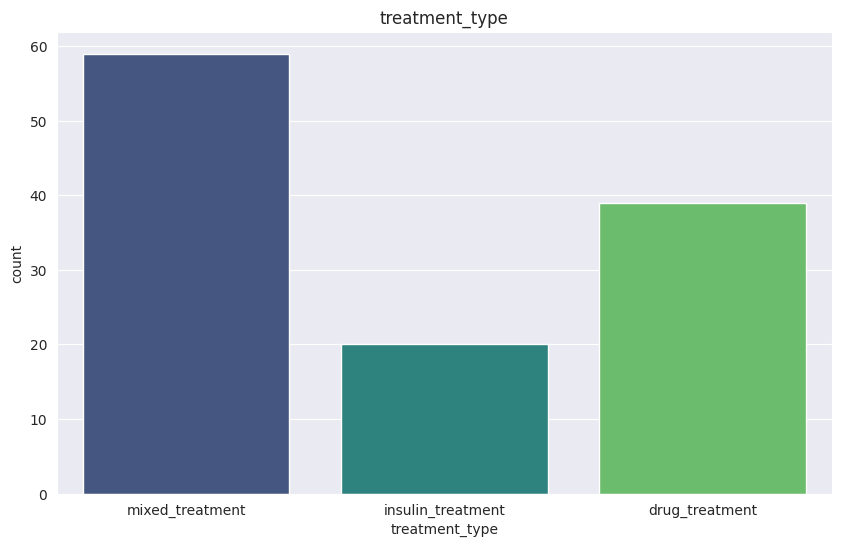

In [177]:
plt.figure(figsize=(10, 6))
sns.countplot(x='treatment_type', hue='treatment_type', data=df, palette='viridis')
plt.title('treatment_type')
plt.show()

# PREDICTIVE ANALYSIS

In [178]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), [
#             'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
#             'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
#             '2-hour Postprandial Plasma Glucose (mg/dl)',
#             'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
#             '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
#             'Total Cholesterol (mmol/L)',
#             'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
#             'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
#             'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)',
#             'Blood Urea Nitrogen (mmol/L)'
#         ]),
#         ('bin', 'passthrough',
#          ['Gender (Female=1, Male=2)', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)',
#           'Type of Diabetes'
#           ])
#     ]
# )
#
# X = df.drop('treatment_type', axis=1)
# y = df['treatment_type']
combined_df

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,has_infectious_diseases,has_kidney_diseases,has_liver_diseases,has_male_reproductive_diseases,has_neurological_and_psychiatric_diseases,has_oncology,has_diabetic_microvascular_complications,has_diabetic_macrovascular__complications,has_acute_diabetic_complications,has_hypoglycemia
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,1,0,10.00,...,0,1,1,0,0,1,1,1,0,0
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,0,0,26.00,...,0,0,0,0,0,0,1,1,1,1
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,0,0,26.00,...,0,0,0,0,0,0,1,1,1,1
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,0,0,26.00,...,0,0,0,0,0,0,1,1,0,1
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,1,0,0.08,...,0,0,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2095_0_20201116,2,66,1.72,62,20.96,0.0,1,1,7.00,...,0,0,0,0,0,0,0,0,0,0
121,2096_0_20201116,1,60,1.57,65,26.37,0.0,1,1,0.10,...,0,0,1,0,0,0,0,0,0,0
122,2097_0_20201116,1,71,1.70,67,23.11,0.0,1,1,20.00,...,0,0,0,0,0,0,0,0,0,0
123,2098_0_20201106,1,64,1.60,67,26.17,0.0,1,1,0.10,...,0,0,1,0,0,0,0,0,0,0


In [179]:
df.shape

(118, 73)

In [180]:
df.head()
df.to_csv('result.csv')

# Define preprocessor

In [181]:
# # df_path = Path('../research/result1.csv')
# # dfTest = pd.read_csv(df_path)
#
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(),
#          ['Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
#           'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
#           '2-hour Postprandial Plasma Glucose (mg/dl)',
#           'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
#           '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
#           'Total Cholesterol (mmol/L)',
#           'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
#           'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
#           'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)',
#           'Blood Urea Nitrogen (mmol/L)']),
#         ('bin', 'passthrough', [
#             'Gender (Female=1, Male=2)', 'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
#             'has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives', 'has_antithrombotic', 'has_arb',
#             'has_calcium_channel_blockers', 'has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment',
#             'has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators', 'has_kidney_support', 'has_laxatives',
#             'has_minerals_and_vitamins', 'has_neuroprotectors', 'has_pancreatic', 'has_probiotics', 'has_psychotropic',
#             'has_thyroid_diseases', 'has_urological_drugs', 'has_vasodilators', 'has_vestibular_disorders',
#             'has_autoimmune_diseases', 'has_cardiovascular_diseases', 'has_dental_diseases',
#             'has_diseases_of_the_musculoskeletal_system', 'has_diseases_of_the_stomach_and_intestines',
#             'has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases', 'has_eye_diseases',
#             'has_gallbladder_diseases',
#             'has_gynecological_diseases', 'has_hematologic_disorders', 'has_infectious_diseases', 'has_kidney_diseases',
#             'has_liver_diseases', 'has_male_reproductive_diseases', 'has_neurological_and_psychiatric_diseases',
#             'has_oncology',
#             'has_diabetic_microvascular_complications', 'has_diabetic_macrovascular__complications',
#             'has_acute_diabetic_complications', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)',
#             'Type of Diabetes'
#         ])
#     ]
# )
#
# X = df.drop('treatment_type', axis=1)
# y = df['treatment_type']

In [182]:
# df.to_csv('result.csv')

In [183]:
# df.tail()

# Create Pipeline / predict and evaluate

## RFC

In [185]:
# from imblearn.over_sampling import SMOTE
#
#
# def run_binary_classification(df, class_a, class_b):
#     print(f"=== classification: {class_a} vs {class_b} ===")
#
#     binary_df = df[df['treatment_type'].isin([class_a, class_b])].copy()
#     X = binary_df.drop(columns=['treatment_type'])
#     y = binary_df['treatment_type']
#
#     categorical_features = [
#         'Gender (Female=1, Male=2)', 'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
#         'has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives', 'has_antithrombotic', 'has_arb',
#         'has_calcium_channel_blockers', 'has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment',
#         'has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators', 'has_kidney_support', 'has_laxatives',
#         'has_minerals_and_vitamins', 'has_neuroprotectors', 'has_pancreatic', 'has_probiotics', 'has_psychotropic',
#         'has_thyroid_diseases', 'has_urological_drugs', 'has_vasodilators', 'has_vestibular_disorders',
#         'has_autoimmune_diseases', 'has_cardiovascular_diseases', 'has_dental_diseases',
#         'has_diseases_of_the_musculoskeletal_system', 'has_diseases_of_the_stomach_and_intestines',
#         'has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases', 'has_eye_diseases',
#         'has_gallbladder_diseases', 'has_gynecological_diseases', 'has_hematologic_disorders',
#         'has_infectious_diseases', 'has_kidney_diseases', 'has_liver_diseases', 'has_male_reproductive_diseases',
#         'has_neurological_and_psychiatric_diseases', 'has_oncology', 'has_diabetic_microvascular_complications',
#         'has_diabetic_macrovascular__complications', 'has_acute_diabetic_complications', 'has_hypoglycemia',
#         'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes'
#     ]
#     numerical_features = [col for col in X.columns if col not in categorical_features]
#
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, stratify=y, test_size=0.2, random_state=42
#     )
#
#     preprocessor = ColumnTransformer([
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])
#
#     over = SMOTE(sampling_strategy='auto', random_state=42)
#
#     pipeline = ImbPipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('over', over),
#         ('classifier', RandomForestClassifier(random_state=42))
#     ])
#
#     param_grid = {
#         'classifier__n_estimators': [200],
#         'classifier__max_depth': [10, 20],
#         'classifier__min_samples_split': [2, 5],
#         'classifier__min_samples_leaf': [1, 2],
#     }
#
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#
#     grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
#     grid.fit(X_train, y_train)
#
#     print("best params:", grid.best_params_)
#     y_pred = grid.predict(X_test)
#     print("accuracy:", round(accuracy_score(y_test, y_pred), 4))
#     print(classification_report(y_test, y_pred))
#
#
# pairs = [
#     ('insulin_treatment', 'drug_treatment'),
#     ('insulin_treatment', 'mixed_treatment'),
#     ('mixed_treatment', 'drug_treatment')
# ]
#
#
# df_path = Path('../research/result2.csv')
# dfTest = pd.read_csv(df_path)
#
# for a, b in pairs:
#     run_binary_classification(dfTest, a, b)

=== classification: insulin_treatment vs drug_treatment ===
best params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
accuracy: 0.8125
                   precision    recall  f1-score   support

   drug_treatment       0.86      0.75      0.80         8
insulin_treatment       0.78      0.88      0.82         8

         accuracy                           0.81        16
        macro avg       0.82      0.81      0.81        16
     weighted avg       0.82      0.81      0.81        16

=== classification: insulin_treatment vs mixed_treatment ===
best params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
accuracy: 0.9375
                   precision    recall  f1-score   support

insulin_treatment       1.00      0.89      0.94         9
  mixed_treatment       0.88      1.00      0.93         7

         accura

In [187]:
from imblearn.over_sampling import SMOTE

df_path = Path('../research/result2.csv')
dfTest = pd.read_csv(df_path)

X = dfTest.drop('treatment_type', axis=1)
y = dfTest['treatment_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

over = SMOTE(sampling_strategy='auto', random_state=42)
# over = SMOTE(sampling_strategy={'insulin_treatment': 26}, random_state=42)


categorical_features = [
    'Gender (Female=1, Male=2)', 'has_ace_inhibitors', 'has_angioprotectors', 'has_antianginal',
    'has_antiarrhythmic', 'has_antibiotics', 'has_antihypertensives', 'has_antithrombotic', 'has_arb',
    'has_calcium_channel_blockers', 'has_circulatory_support', 'has_gastroprotective', 'has_gout_treatment',
    'has_hepatoprotector', 'has_hypolipidemic', 'has_immunomodulators', 'has_kidney_support', 'has_laxatives',
    'has_minerals_and_vitamins', 'has_neuroprotectors', 'has_pancreatic', 'has_probiotics', 'has_psychotropic',
    'has_thyroid_diseases', 'has_urological_drugs', 'has_vasodilators', 'has_vestibular_disorders',
    'has_autoimmune_diseases', 'has_cardiovascular_diseases', 'has_dental_diseases',
    'has_diseases_of_the_musculoskeletal_system', 'has_diseases_of_the_stomach_and_intestines',
    'has_electrolyte_and_mineral_disorders', 'has_endocrine_diseases', 'has_eye_diseases',
    'has_gallbladder_diseases', 'has_gynecological_diseases', 'has_hematologic_disorders',
    'has_infectious_diseases', 'has_kidney_diseases', 'has_liver_diseases', 'has_male_reproductive_diseases',
    'has_neurological_and_psychiatric_diseases', 'has_oncology', 'has_diabetic_microvascular_complications',
    'has_diabetic_macrovascular__complications', 'has_acute_diabetic_complications', 'has_hypoglycemia',
    'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes'
]
numerical_features = [col for col in X.columns if col not in categorical_features]
# cat_idx = [X.columns.get_loc(col) for col in categorical_features]

# over = SMOTE(categorical_features=cat_idx, sampling_strategy={'insulin_treatment': 26}, random_state=42)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', 'passthrough', categorical_features)
])
# ova_classifier = OneVsOneClassifier(RandomForestClassifier(random_state=42))

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    # ('classifier', ova_classifier),
    ('classifier', RandomForestClassifier(random_state=42)),
])
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}
# param_grid = {
#     'classifier__estimator__n_estimators': [200, 300],
#     'classifier__estimator__max_depth': [10, 20],
#     'classifier__estimator__min_samples_split': [2, 5, 10],
#     'classifier__estimator__min_samples_leaf': [1, 2, 4],
# }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Accuracy: 0.7917
                   precision    recall  f1-score   support

   drug_treatment       0.86      0.75      0.80         8
insulin_treatment       0.75      0.67      0.71         9
  mixed_treatment       0.78      1.00      0.88         7

         accuracy                           0.79        24
        macro avg       0.79      0.81      0.79        24
     weighted avg       0.79      0.79      0.79        24



In [191]:
print(y.value_counts(normalize=True))

treatment_type
mixed_treatment      0.500000
drug_treatment       0.330508
insulin_treatment    0.169492
Name: proportion, dtype: float64


In [192]:
y_train.value_counts()

treatment_type
mixed_treatment      47
drug_treatment       31
insulin_treatment    16
Name: count, dtype: int64

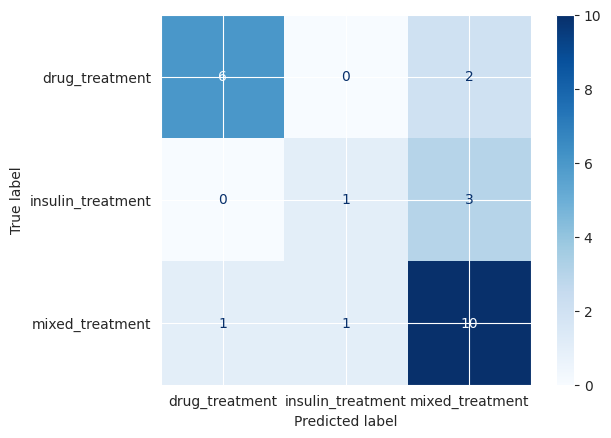

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, cmap='Blues')

In [69]:
print("Train accuracy:", accuracy_score(y_train, grid_search.predict(X_train)))

Train accuracy: 0.9680851063829787


In [329]:
print(y_train.value_counts())
print(y_test.value_counts())

treatment_type
mixed_treatment      47
drug_treatment       31
insulin_treatment    16
Name: count, dtype: int64
treatment_type
mixed_treatment      12
drug_treatment        8
insulin_treatment     4
Name: count, dtype: int64


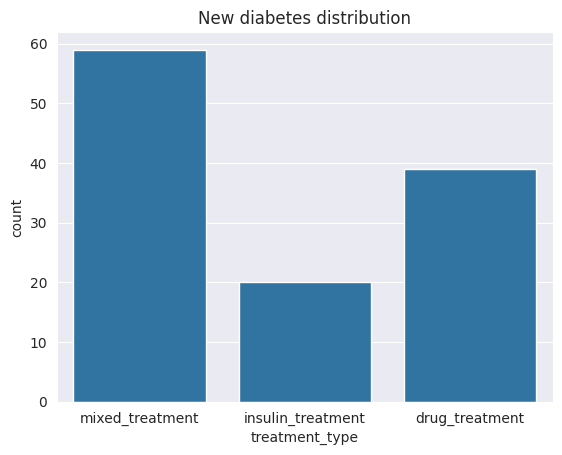

In [46]:
sns.countplot(data=df, x='treatment_type')
plt.title('New diabetes distribution')
plt.show()

In [49]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50],
    'classifier__max_depth': [20],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [2]
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [50]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=skf,
    n_jobs=-1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


In [51]:
y_pred = grid_search.predict(X_test)

print("Accuracy on test:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

Accuracy on test: 0.8214
                   precision    recall  f1-score   support

   drug_treatment       1.00      0.64      0.78        14
insulin_treatment       0.74      1.00      0.85        14

         accuracy                           0.82        28
        macro avg       0.87      0.82      0.82        28
     weighted avg       0.87      0.82      0.82        28



In [52]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.8214285714285714
                   precision    recall  f1-score   support

   drug_treatment       1.00      0.64      0.78        14
insulin_treatment       0.74      1.00      0.85        14

         accuracy                           0.82        28
        macro avg       0.87      0.82      0.82        28
     weighted avg       0.87      0.82      0.82        28



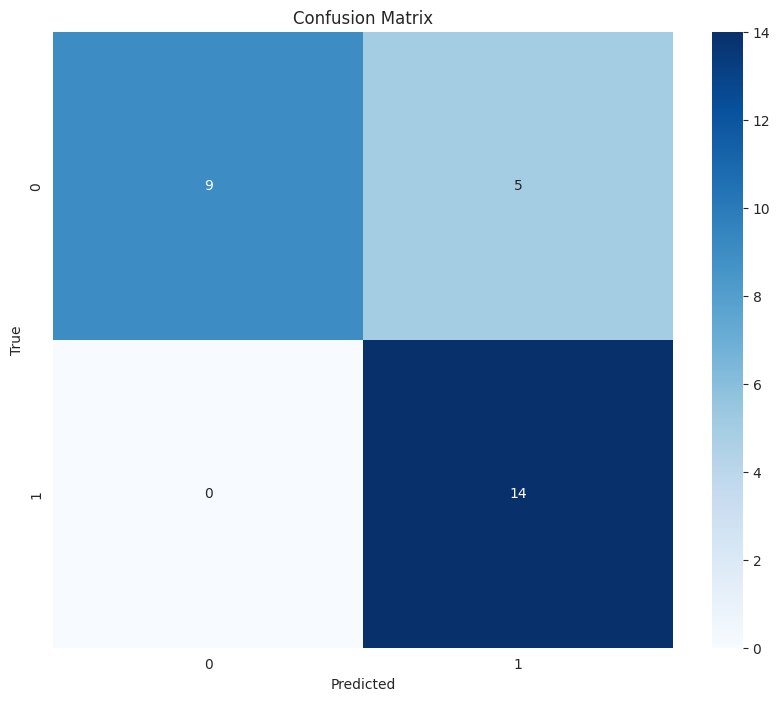

In [53]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [54]:
print(sorted(y.unique()))

['drug_treatment', 'insulin_treatment']


### DTC

In [55]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [56]:
param_grid = {
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_depth': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_leaf_nodes': [10, 20, 50],
}

In [57]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

KeyboardInterrupt: 

In [283]:
y_pred = grid_search.predict(X_test)
print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.7916666666666666
                   precision    recall  f1-score   support

   drug_treatment       1.00      0.44      0.62         9
insulin_treatment       0.75      1.00      0.86        15

         accuracy                           0.79        24
        macro avg       0.88      0.72      0.74        24
     weighted avg       0.84      0.79      0.77        24



In [116]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

best parameters {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
model accuracy 0.6666666666666666
                   precision    recall  f1-score   support

   drug_treatment       0.56      0.56      0.56         9
insulin_treatment       0.73      0.73      0.73        15

         accuracy                           0.67        24
        macro avg       0.64      0.64      0.64        24
     weighted avg       0.67      0.67      0.67        24



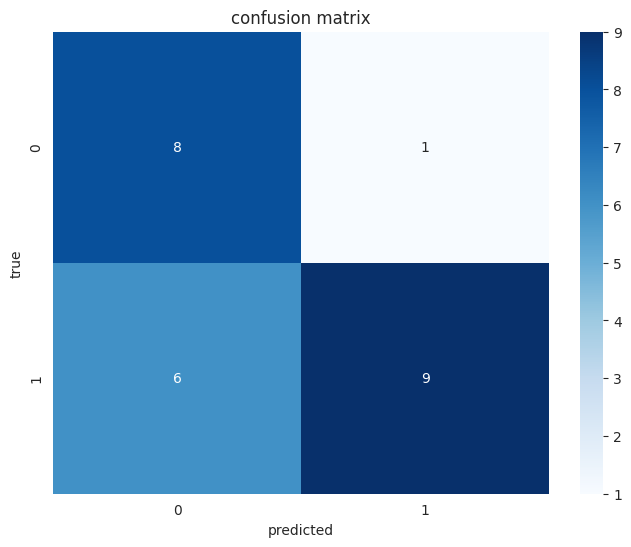

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## KNN

In [41]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
)

In [42]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2],
    'classifier__weights': ['uniform', 'distance'],
}

In [43]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}


In [44]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.6666666666666666
                   precision    recall  f1-score   support

   drug_treatment       0.54      0.78      0.64         9
insulin_treatment       0.82      0.60      0.69        15

         accuracy                           0.67        24
        macro avg       0.68      0.69      0.66        24
     weighted avg       0.71      0.67      0.67        24



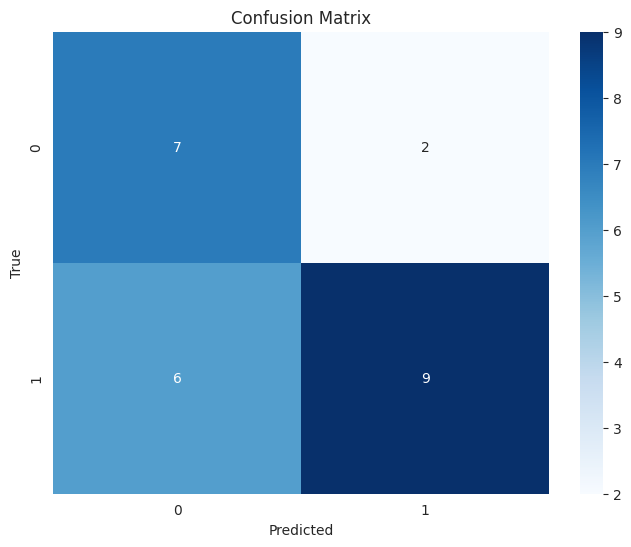

In [45]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## LR

In [46]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]
)

In [47]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [300, 500, 1000]
}

In [48]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

best parameters {'classifier__C': 1, 'classifier__max_iter': 300, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [49]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


model accuracy 0.875
                   precision    recall  f1-score   support

   drug_treatment       0.80      0.89      0.84         9
insulin_treatment       0.93      0.87      0.90        15

         accuracy                           0.88        24
        macro avg       0.86      0.88      0.87        24
     weighted avg       0.88      0.88      0.88        24



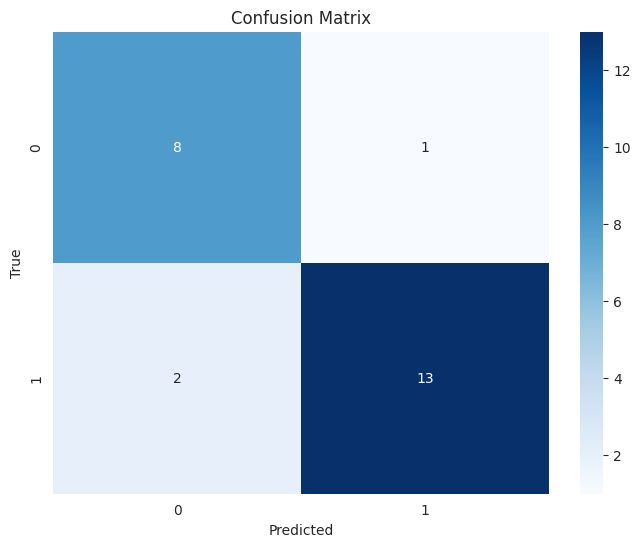

In [50]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## XGBoost

In [673]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=42))
    ]
)

In [674]:
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200],
    'classifier__subsample': [0.8, 1.0],
}

In [675]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [676]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.8333333333333334
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.82      0.93      0.88        15

    accuracy                           0.83        24
   macro avg       0.84      0.80      0.81        24
weighted avg       0.84      0.83      0.83        24



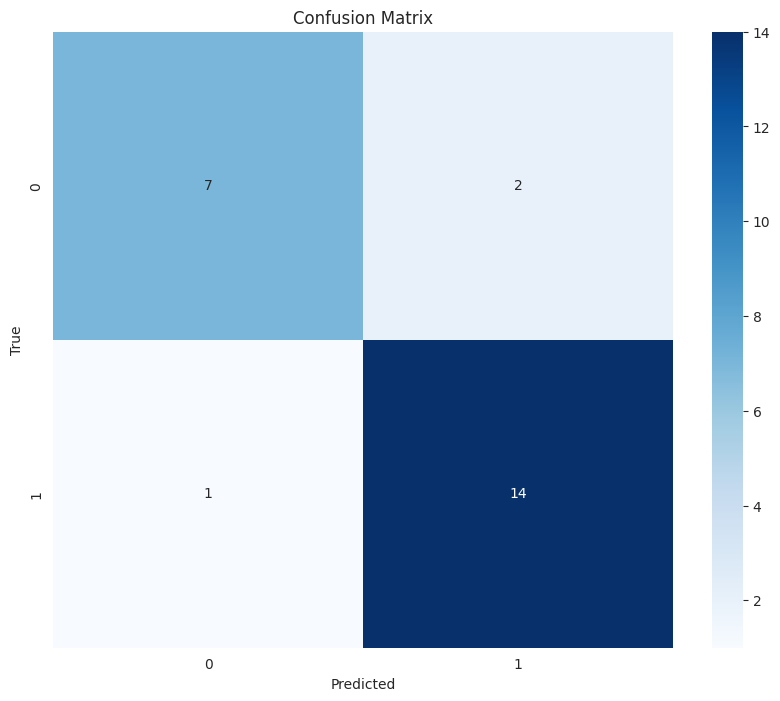

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Lightgbm

In [56]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(verbose=-1))
    ]
)

In [57]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [15, 31],
    'classifier__min_child_samples': [10, 20, 30],
}

In [58]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature

best parameters {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_samples': 20, 'classifier__n_estimators': 200, 'classifier__num_leaves': 15}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [59]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.75
                   precision    recall  f1-score   support

   drug_treatment       0.71      0.56      0.62         9
insulin_treatment       0.76      0.87      0.81        15

         accuracy                           0.75        24
        macro avg       0.74      0.71      0.72        24
     weighted avg       0.75      0.75      0.74        24



/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


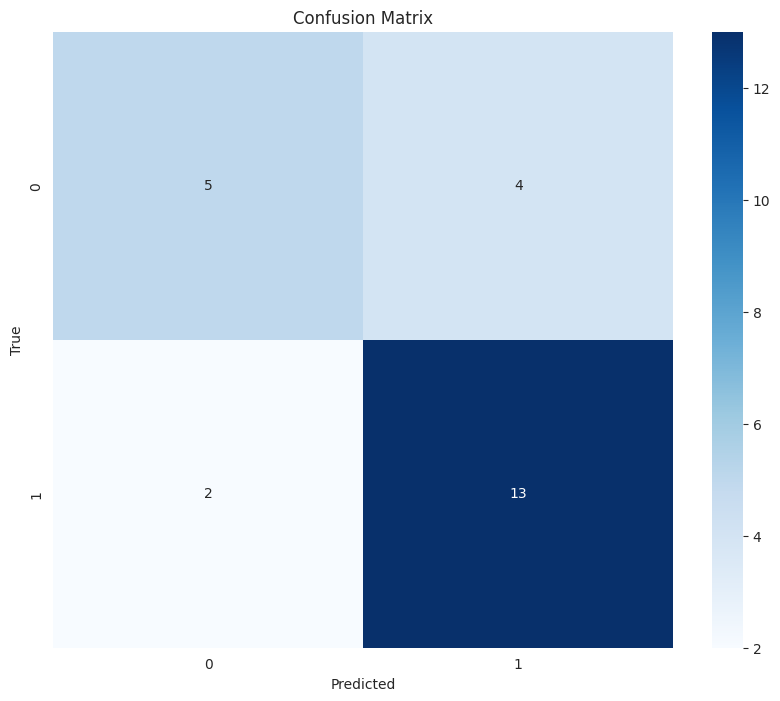

In [60]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()